# Run the pipeline

Step 1: Set the environment variable for the 'CRDS_PATH'. Check out the [jwst docs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/reference_files_crds.html) for more info.

Step 2: Run the pipeline!

The outputs from the two steps are put into two folders. The 'uncal' files go into the 'stage1' folder, and the 'stage1' files go into the 'calgrp' folder.

In [1]:
from amigo.pipelines import process_stage0, process_stage1
import os

os.environ["CRDS_PATH"] = "/Users/louis/Data/JWST/crds_cache"
dirs = [
    "/Users/louis/Data/JWST/amigo_data/ERS1386/uncal/",
    "/Users/louis/Data/JWST/amigo_data/COMM1903/uncal/",
    "/Users/louis/Data/JWST/amigo_data/GO1843/uncal/",
    "/Users/louis/Data/JWST/amigo_data/GTO1242/uncal/",
    "/Users/louis/Data/JWST/amigo_data/CAL1516/uncal/",
]

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


ModuleNotFoundError: No module named 'pyia'

In [ ]:
for directory in dirs:
    stage1_dir = process_stage0(directory)
    calgrps_dir = process_stage1(stage1_dir)

Running stage 1...
File already exists, skipping...
Not a NIS_AMI file, skipping...
Not a NIS_AMI file, skipping...
File already exists, skipping...
Not a NIS_AMI file, skipping...
Not a NIS_AMI file, skipping...
Not a NIS_AMI file, skipping...
Not a NIS_AMI file, skipping...
Not a NIS_AMI file, skipping...
Not a NIS_AMI file, skipping...
File already exists, skipping...
File already exists, skipping...
Not a NIS_AMI file, skipping...
Not a NIS_AMI file, skipping...
File already exists, skipping...
Not a NIS_AMI file, skipping...
File already exists, skipping...
Not a NIS_AMI file, skipping...
Done

Running calgrps processing...
File already exists, skipping...
File already exists, skipping...
File already exists, skipping...
File already exists, skipping...
File already exists, skipping...
File already exists, skipping...
Done

Running stage 1...
File already exists, skipping...
Not a NIS_AMI file, skipping...
File already exists, skipping...
File already exists, skipping...
File alre

---

# Look at the data

Now lets examine the output of the stage 1 pipeline.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

(950, 13, 80, 80)


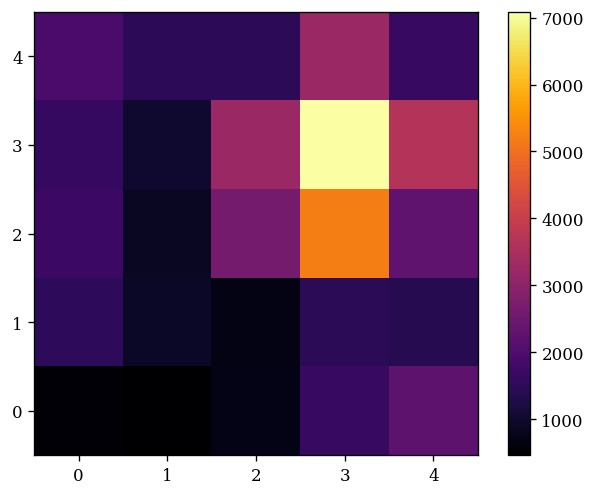

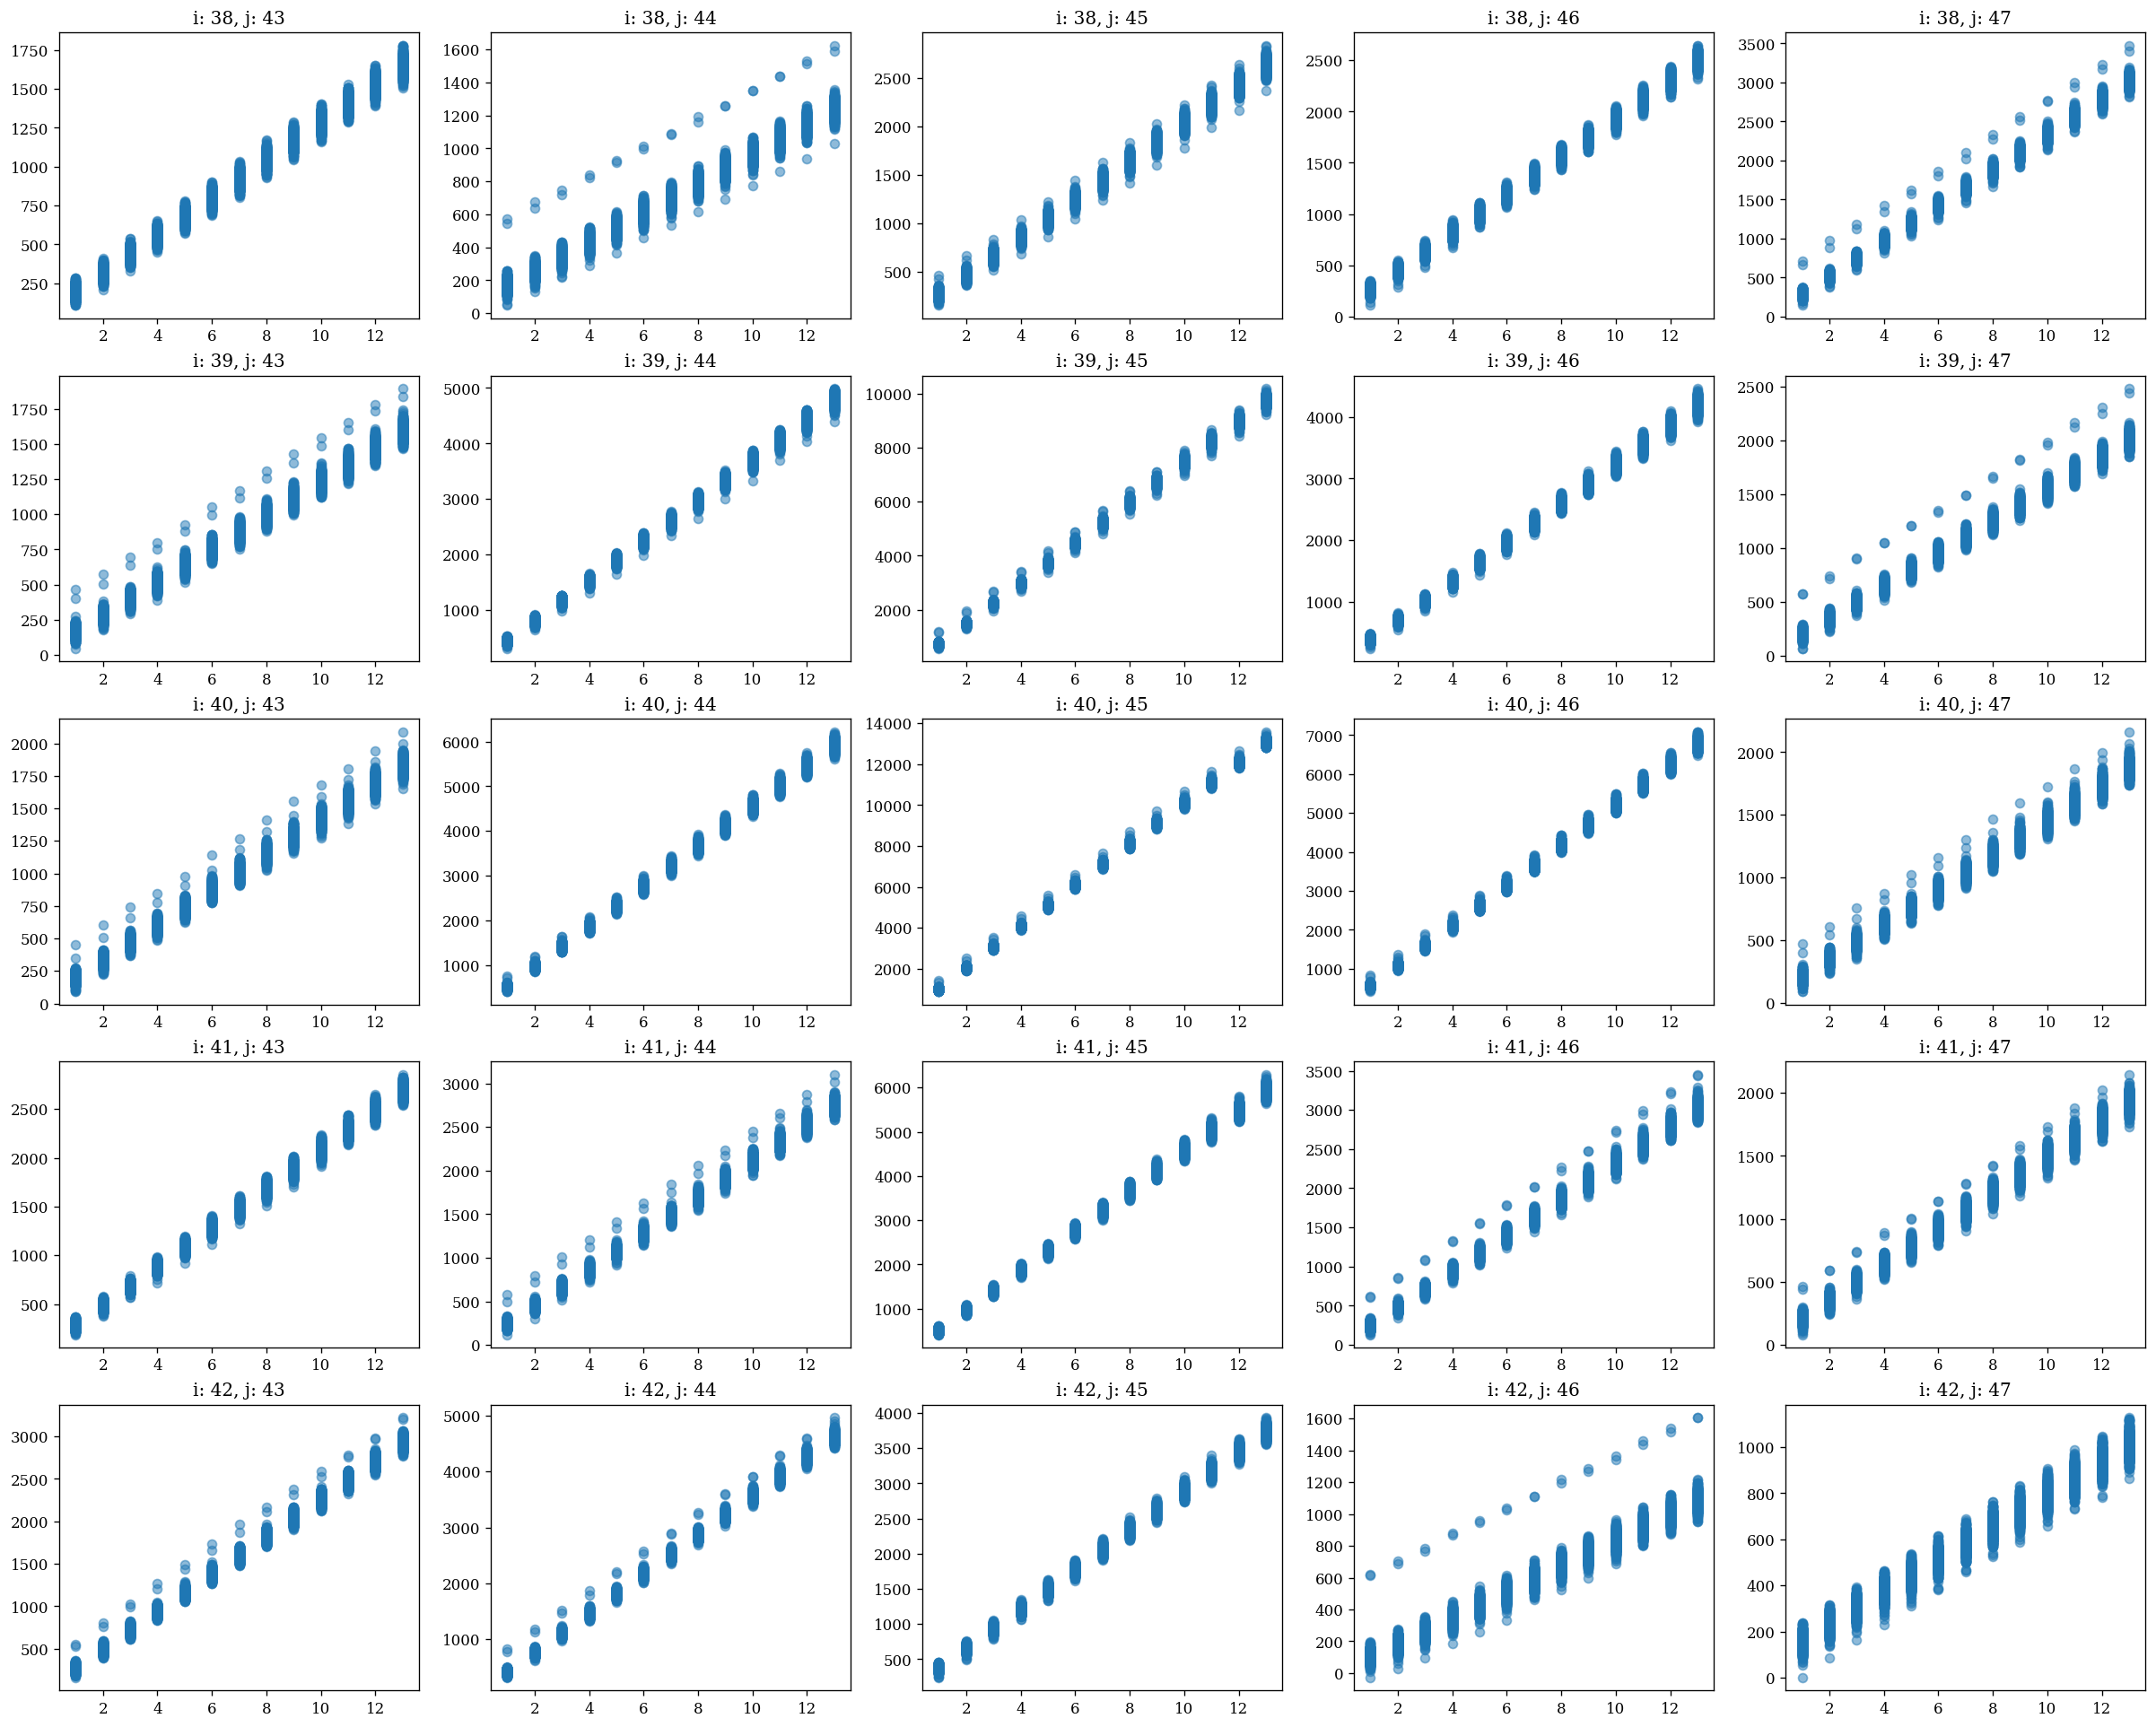

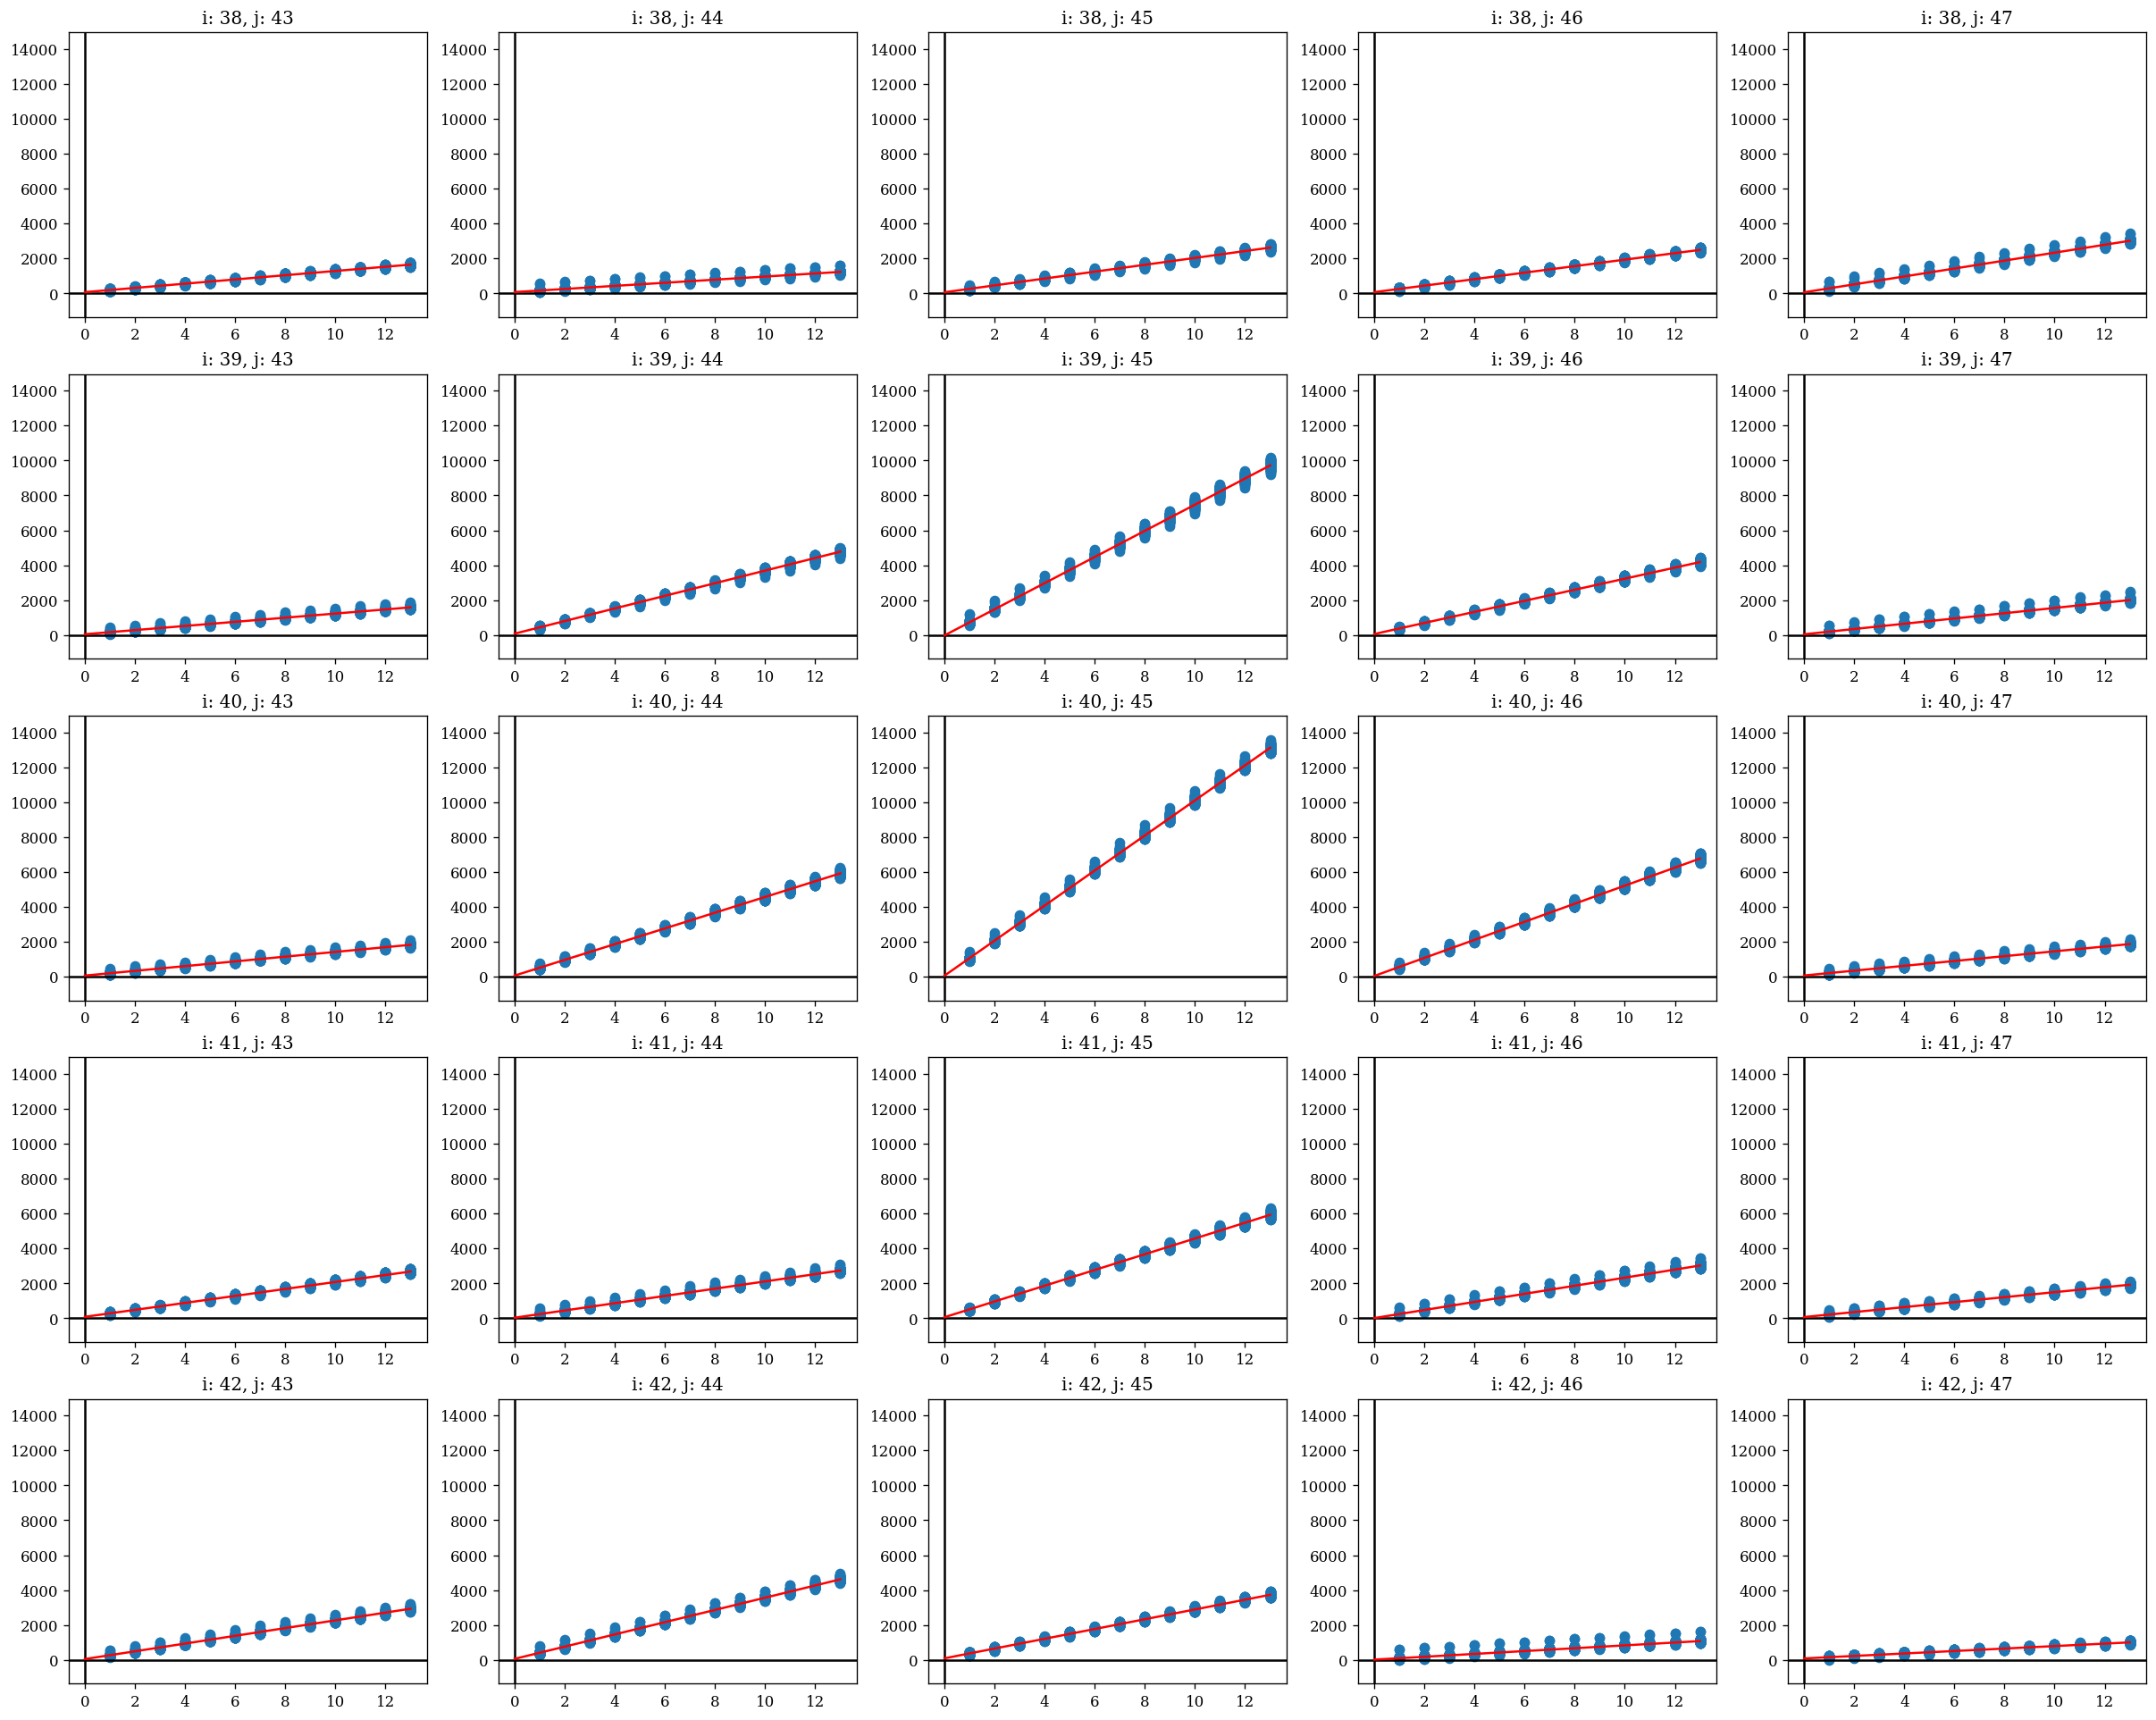

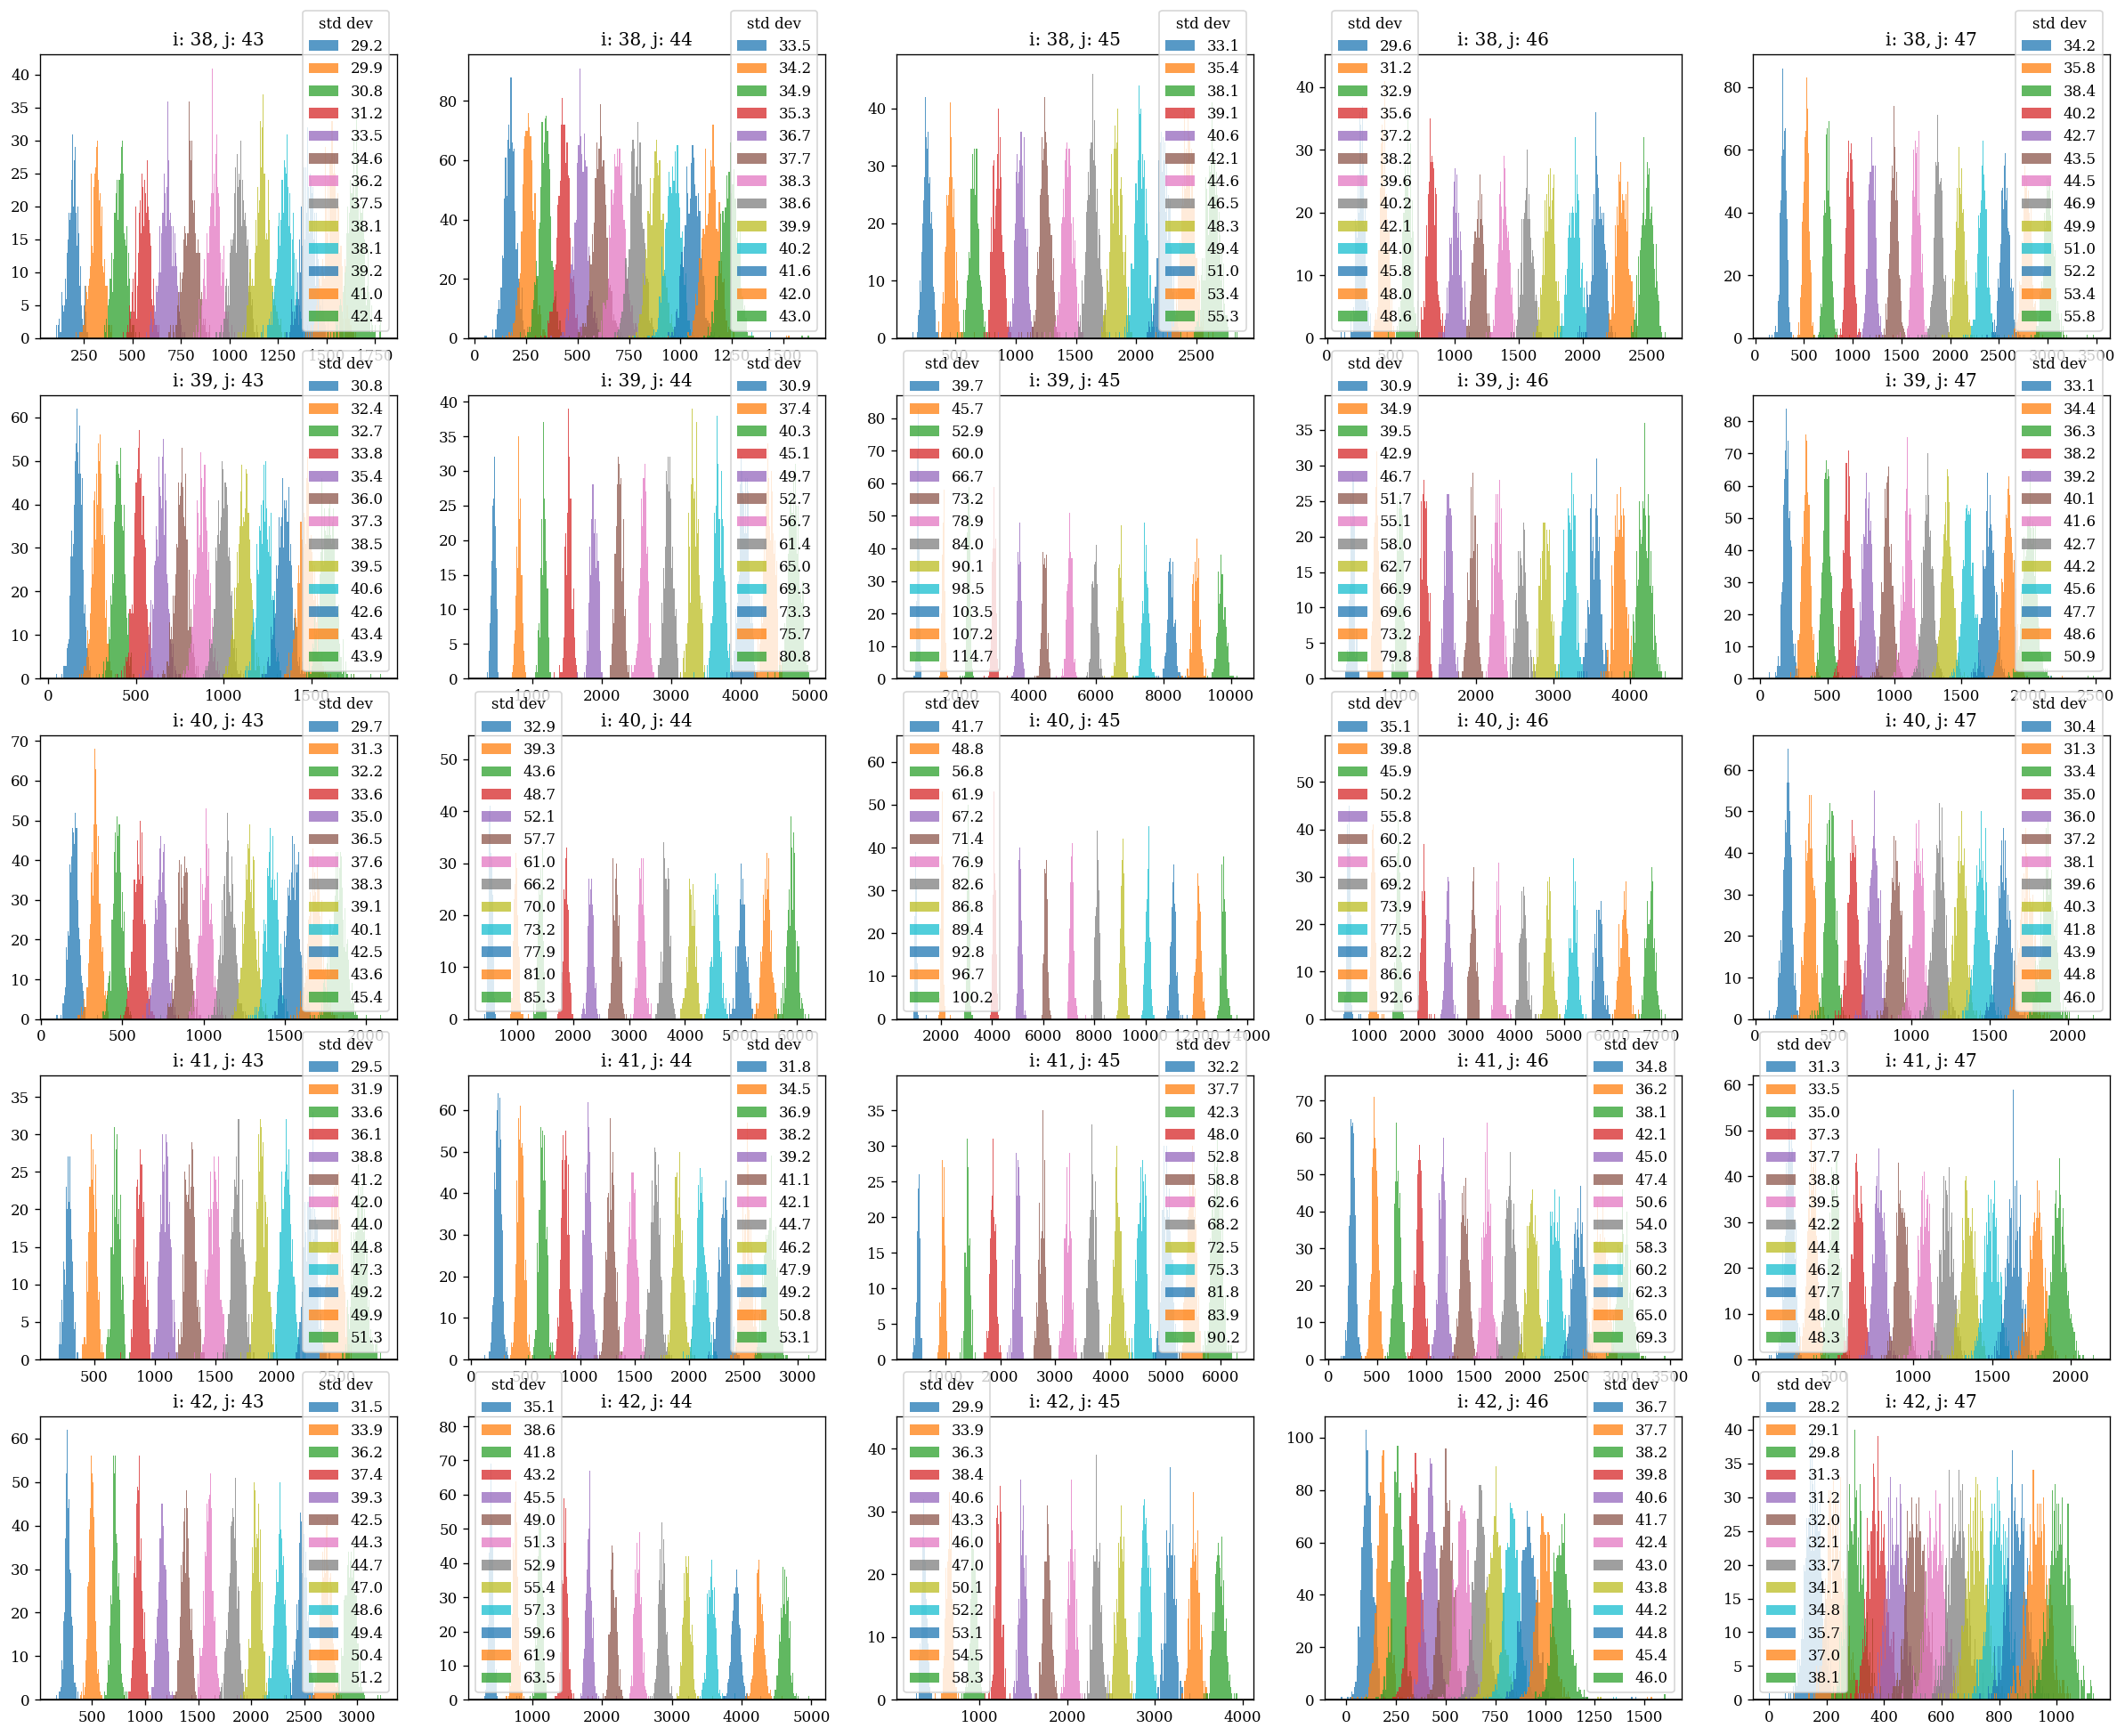

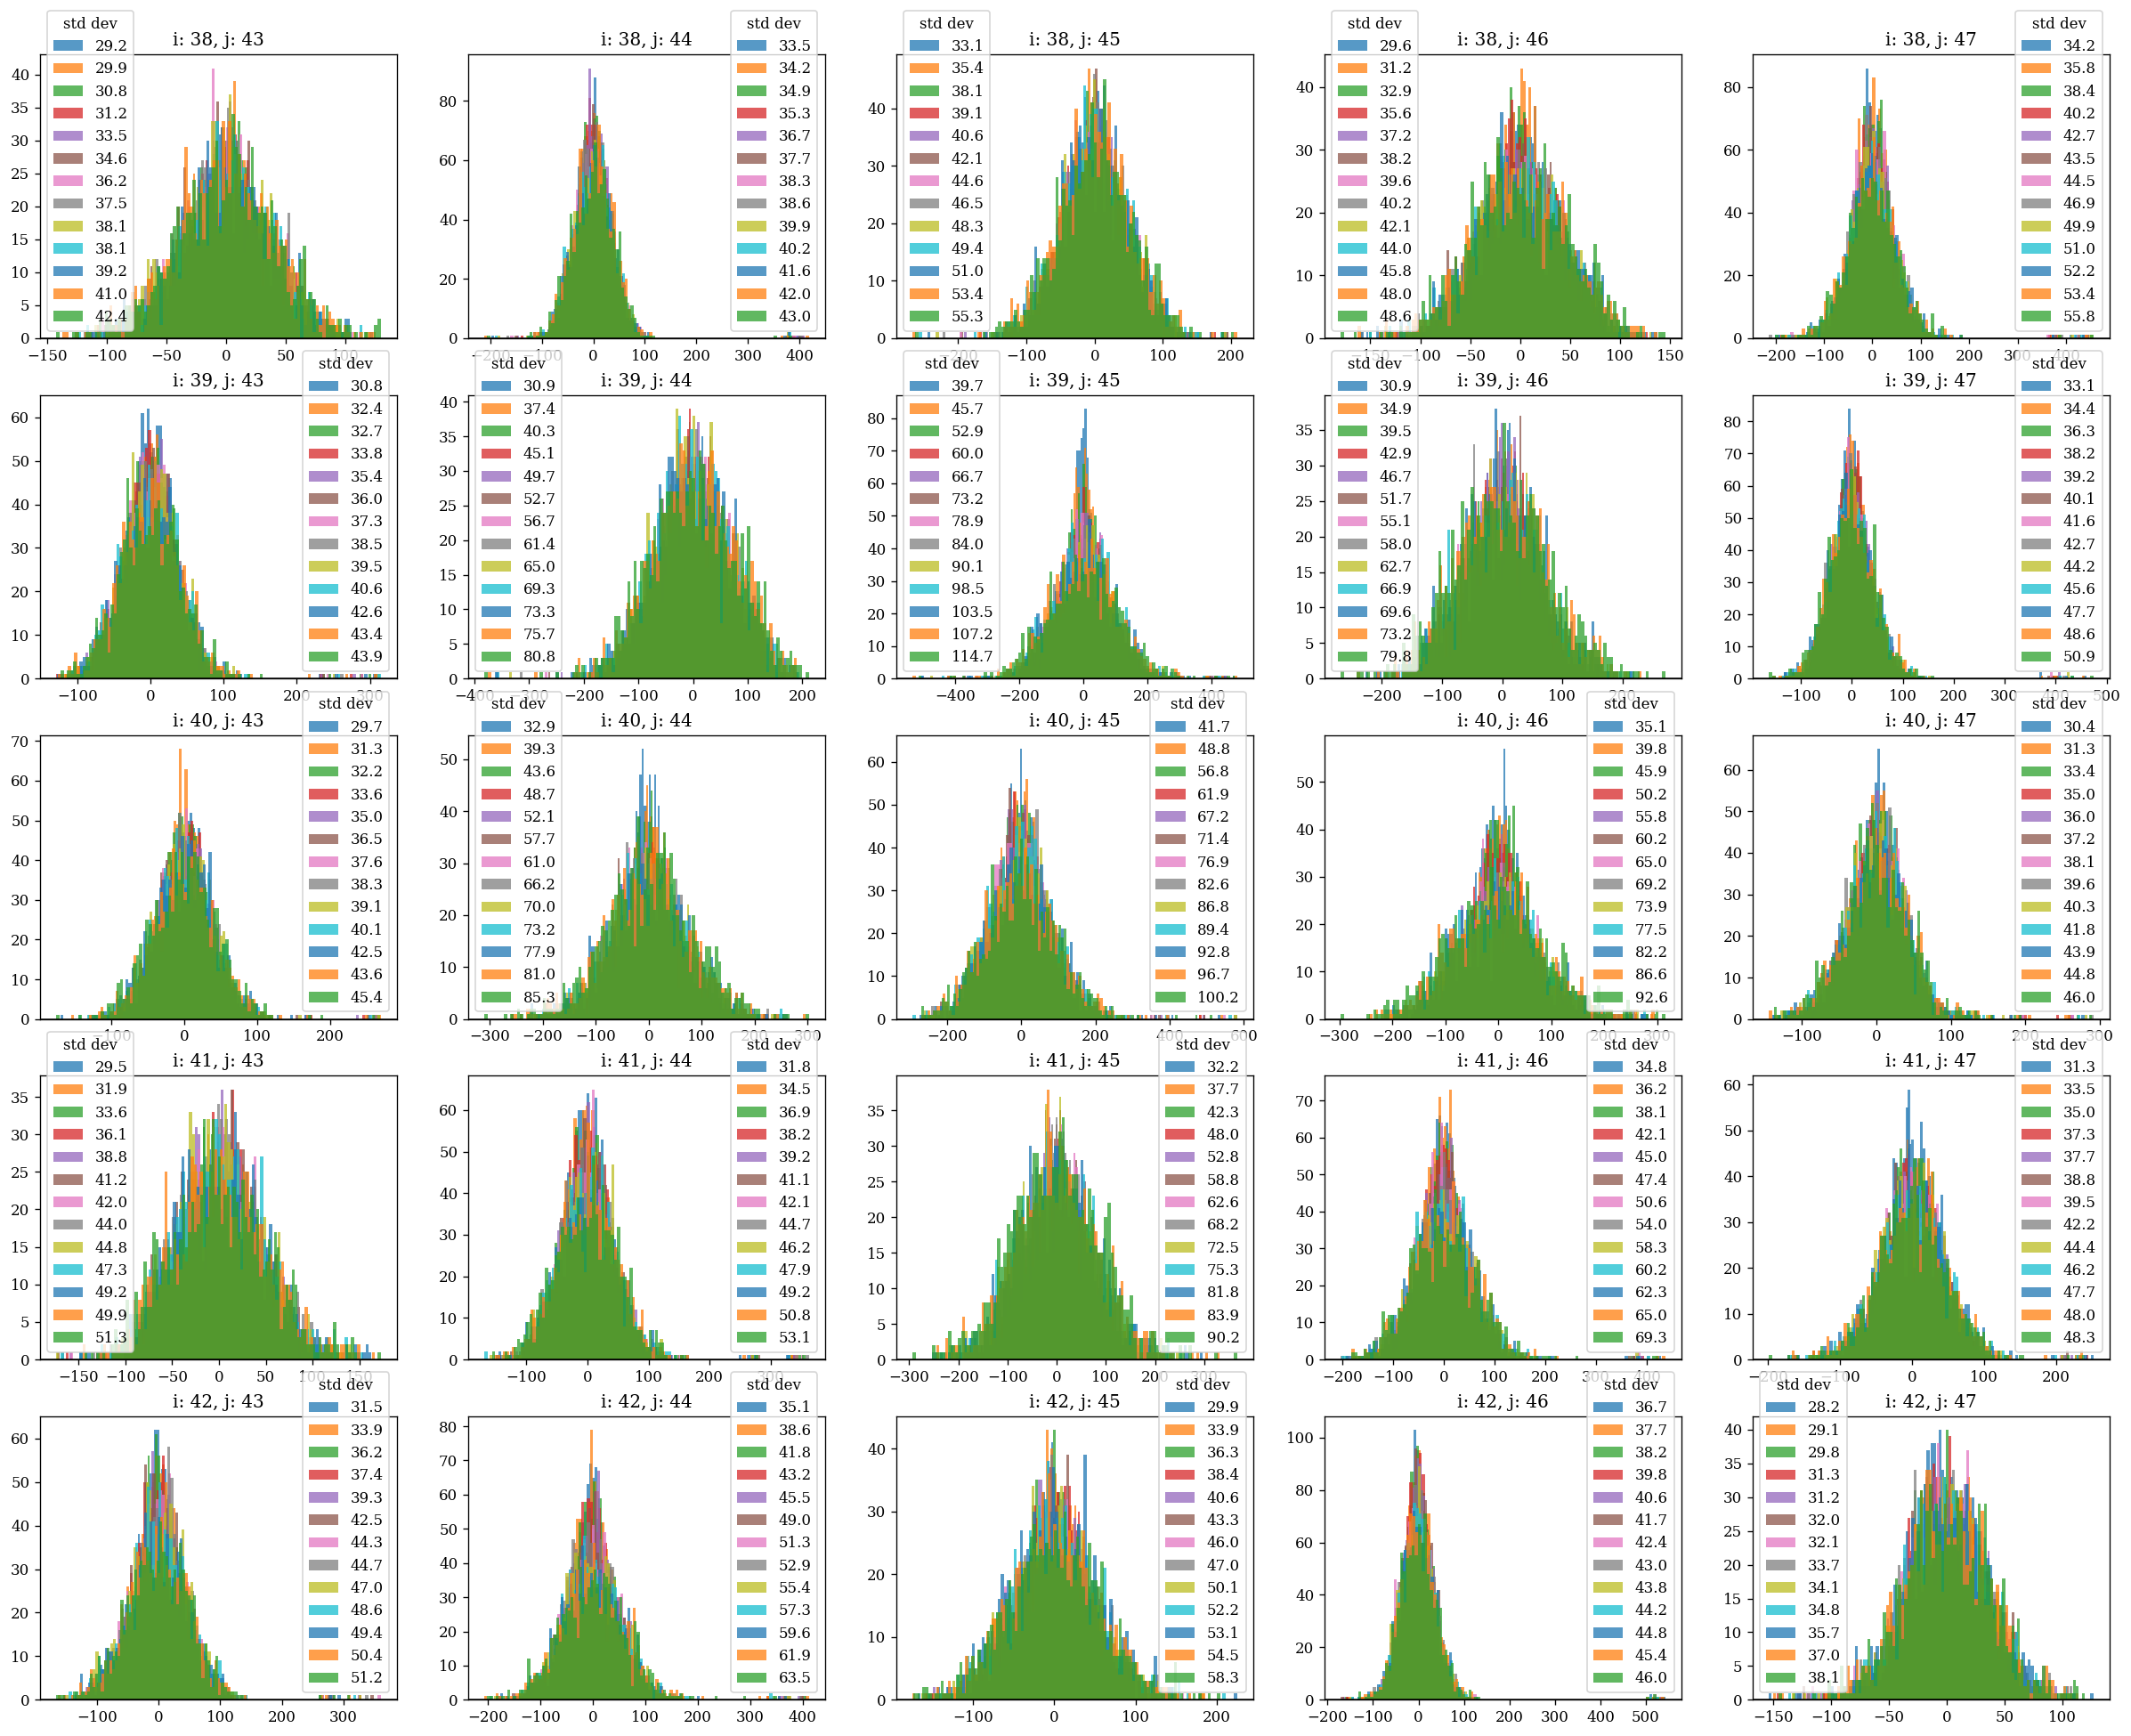

In [ ]:
import os
import jax.numpy as np
from astropy.io import fits
from amigo.misc import fit_slope
from jax import vmap

file_path = "/Users/louis/Data/JWST/amigo_data/ERS1386/stage1/"
file_paths = os.listdir(file_path)
file = fits.open(file_path + file_paths[0])
data = np.asarray(file['SCI'].data, float)
print(data.shape)

cen = (40, 45)
s = 5
k = (s+1) // 2
Is, Js = cen[0] + np.arange(-k, k), cen[1] + np.arange(-k, k)

im = data[:, :, cen[0] - k: cen[0] + k - 1, cen[1] - k: cen[1] + k - 1]
plt.imshow(im.mean(0).mean(0))
plt.colorbar()
plt.show()

vmax = np.max(im)
nints = len(data)
ngroups = len(data[0])
ys = data.reshape(nints, ngroups, 80, 80)
xs = np.tile(np.arange(1, ngroups+1), nints).reshape(nints, ngroups)

plt.figure(figsize=(25, 20))
for i in range(s):
    for j in range(s):
        _i = cen[0] + i - (s//2)
        _j = cen[1] + j - (s//2)

        plt.subplot(s, s, i * s + j + 1)
        plt.title(f"i: {_i}, j: {_j}")
        plt.scatter(xs, ys[:, :, _i, _j], alpha=0.5)

plt.figure(figsize=(25, 20))
for i in range(s):
    for j in range(s):
        _i = cen[0] + i - (s//2)
        _j = cen[1] + j - (s//2)
        ms, bs = vmap(fit_slope)(ys[:, :, _i, _j])

        plt.subplot(s, s, i * s + j + 1)
        plt.title(f"i: {_i}, j: {_j}")
        plt.axhline(y=0, color="k")
        plt.axvline(x=0, color="k")
        plt.ylim(-.1 * vmax, 1.1* vmax)
        plt.scatter(xs, ys[:, :, _i, _j])

        x = np.arange(0, ngroups+1)
        y = ms[:, None] * x[None, :] + bs[:, None]
        plt.plot(x, y.mean(0), color="r")

plt.figure(figsize=(25, 20))
for i in range(s):
    for j in range(s):
        _i = cen[0] + i - (s//2)
        _j = cen[1] + j - (s//2)

        plt.subplot(s, s, i * s + j + 1)
        plt.title(f"i: {_i}, j: {_j}")
        y_in = ys[:, :, _i, _j]
        alphas = [1, 0.8, 0.5]
        cols = ["tab:blue", "tab:orange", "tab:green"]
        for l in np.arange(ngroups):
            plt.hist(y_in[:, l], bins=100, alpha=0.75, label=f"{y_in[:, l].std():,.1f}")
        plt.axhline(y=0, color="k")
        plt.legend(title="std dev")

plt.figure(figsize=(25, 20))
for i in range(s):
    for j in range(s):
        _i = cen[0] + i - (s//2)
        _j = cen[1] + j - (s//2)

        plt.subplot(s, s, i * s + j + 1)
        plt.title(f"i: {_i}, j: {_j}")
        y_in = ys[:, :, _i, _j]
        y_in -= y_in.mean(0)
        alphas = [1, 0.6, 0.4]
        cols = ["tab:blue", "tab:orange", "tab:green"]
        for l in np.arange(ngroups):
            plt.hist(y_in[:, l], bins=100, alpha=0.75, label=f"{y_in[:, l].std():,.1f}")
        plt.axhline(y=0, color="k")
        plt.legend(title="std dev")